In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, auc, roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import optuna

try:
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cb
    EXTERNAL_BOOSTERS_AVAILABLE = True
except ImportError:
    EXTERNAL_BOOSTERS_AVAILABLE = False
    print("Внешние библиотеки (LGBM, XGB, CB) не найдены. Сравнение будет ограничено Sklearn.")

warnings.filterwarnings('ignore')
np.random.seed(42)
random.seed(42)
pd.set_option('display.max_columns', None)

Внешние библиотеки (LGBM, XGB, CB) не найдены. Сравнение будет ограничено Sklearn.


## 2. Загрузка данных и Подготовка
Устранение всех предыдущих ошибок: безопасное удаление колонок, удаление строк с `NaN` в целевой переменной, корректное формирование признаков.

In [ ]:
def preprocess_dates(df):
    df = df.copy()
    if 'ApplicationDate' in df.columns:
        df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], errors='coerce')
        
        df['App_Year'] = df['ApplicationDate'].dt.year.fillna(0).astype(int)
        df['App_Month'] = df['ApplicationDate'].dt.month.fillna(0).astype(int)
        
        df = df.drop('ApplicationDate', axis=1)
    return df

try:
    train_df = pd.read_csv('train_c.csv')
    test_df = pd.read_csv('test_c.csv')
    print(f"Данные загружены. Train: {train_df.shape}, Test: {test_df.shape}")
except FileNotFoundError:
    print("Файлы не найдены. Генерируем синтетические данные для демонстрации работы кода.")
    cols = ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'MonthlyDebtPayments', 'MaritalStatus', 'LoanPurpose', 'EmploymentStatus']
    train_df = pd.DataFrame(np.random.rand(500, len(cols)), columns=cols)
    train_df['ID'] = range(500)
    train_df['ApplicationDate'] = '2023-01-01'
    train_df['Loan Approved'] = np.random.randint(0, 2, 500)
    train_df.loc[0, 'Loan Approved'] = np.nan
    cat_cols_mock = ['MaritalStatus', 'LoanPurpose', 'EmploymentStatus']
    for c in cat_cols_mock:
        train_df[c] = np.random.choice(['A', 'B', 'C'], 500)
    
    test_df = train_df.drop('Loan Approved', axis=1, errors='ignore').copy()
    test_df['ID'] = range(500, 1000)

train_df = preprocess_dates(train_df)
test_df = preprocess_dates(test_df)

target_col = 'Loan Approved' if 'Loan Approved' in train_df.columns else 'LoanApproved'
print(f"Целевая переменная: {target_col}")

X = train_df.drop(columns=['ID', target_col], errors='ignore')
y = train_df[target_col]

if y.isnull().any():
    print("Внимание: Обнаружены пропуски в целевой переменной. Удаляем соответствующие строки.")
    valid_indices = y.dropna().index
    X = X.loc[valid_indices].reset_index(drop=True)
    y = y.loc[valid_indices].reset_index(drop=True)
    print(f"Размерность данных после очистки: X={X.shape}, y={y.shape}")

X_test_submission = test_df.drop(columns=['ID'], errors='ignore')

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Количество признаков для обучения: {X.shape[1]}")

Данные загружены. Train: (11017, 35), Test: (5000, 35)
Целевая переменная: LoanApproved
Внимание: Обнаружены пропуски в целевой переменной. Удаляем соответствующие строки.
Размерность данных после очистки: X=(10487, 35), y=(10487,)
Количество признаков для обучения: 35


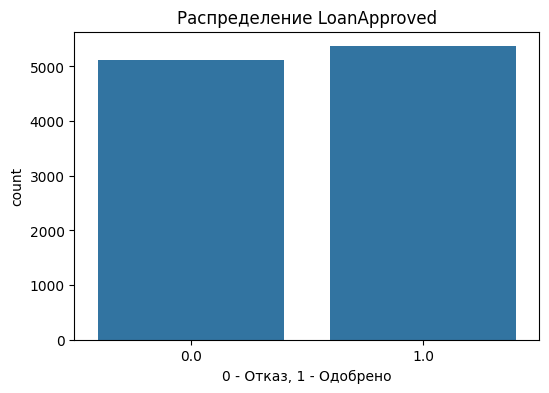

Доля положительного класса: 51.18%

Признаки с наибольшим количеством пропусков:
CreditScore            501
MonthlyDebtPayments    501
LoanAmount             501
NetWorth               501
BaseInterestRate       501
dtype: int64


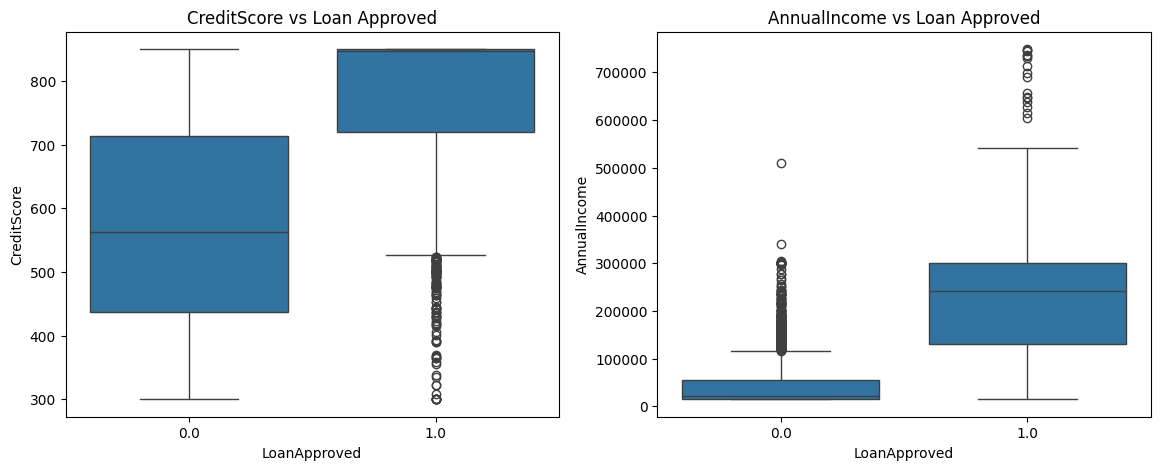

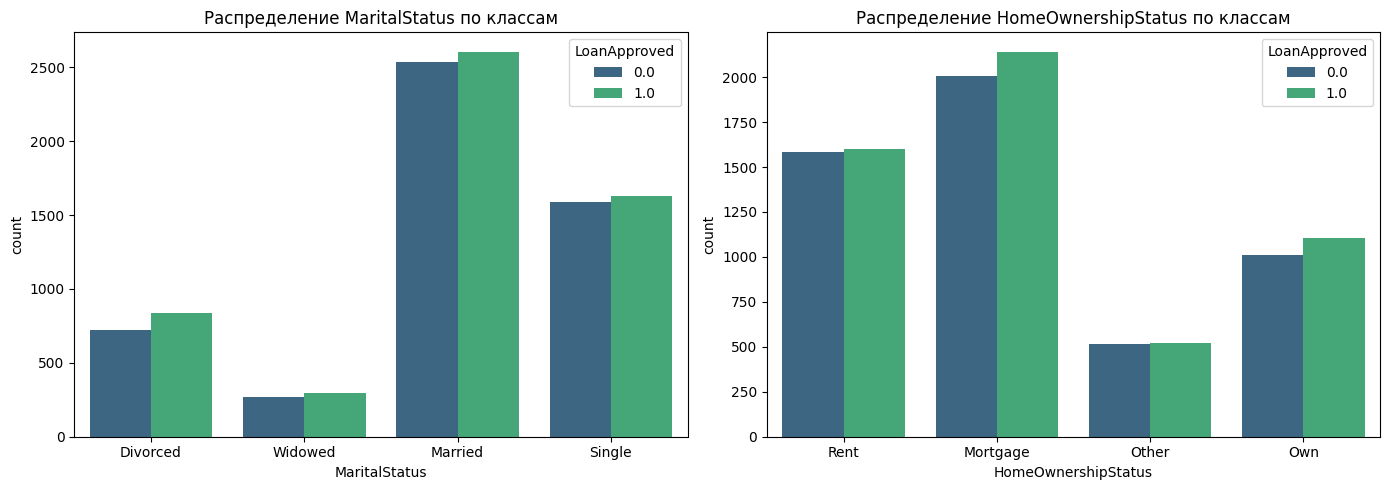

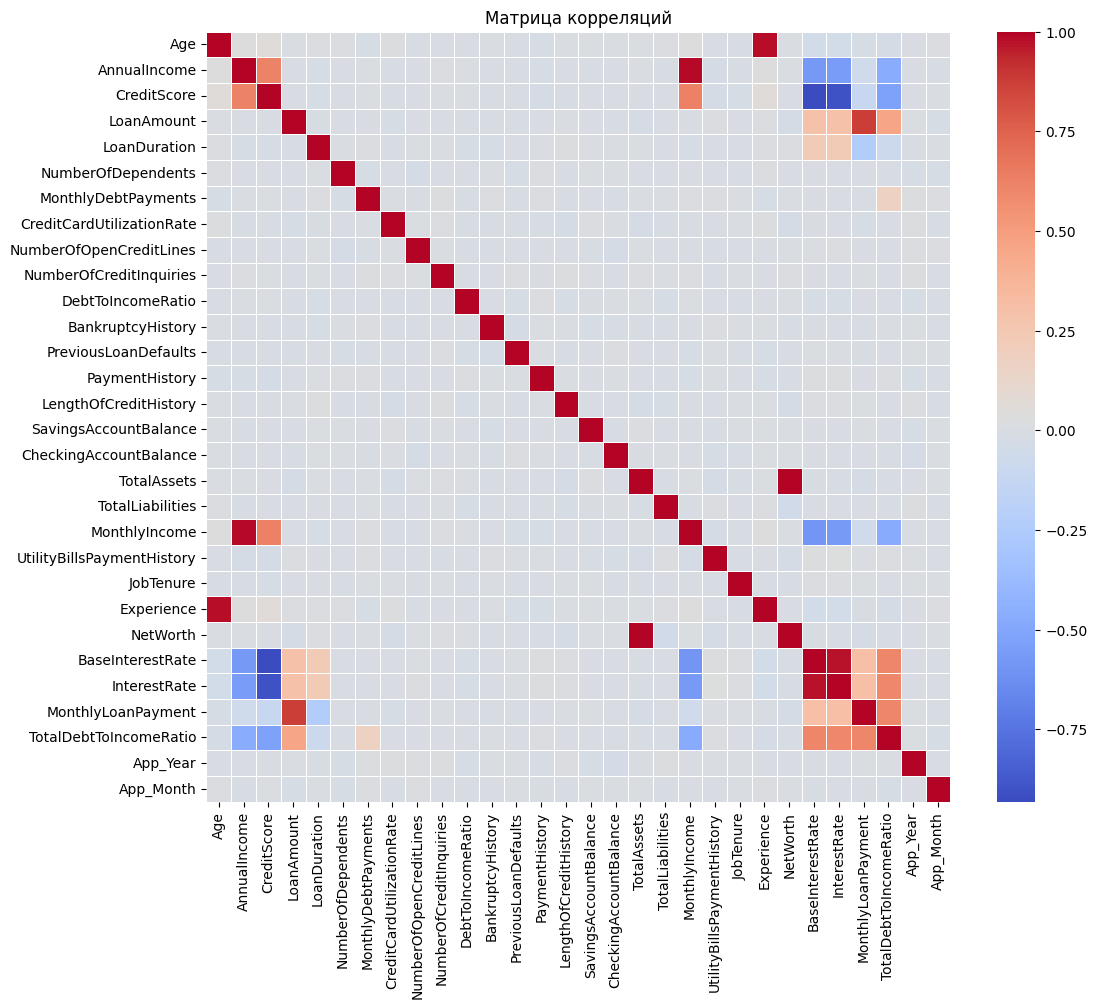

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title(f'Распределение {target_col}')
plt.xlabel('0 - Отказ, 1 - Одобрено')
plt.show()


print(f"Доля положительного класса: {y.mean():.2%}")

# Пропуски
missing = X.isnull().sum().sort_values(ascending=False)
print("\nПризнаки с наибольшим количеством пропусков:")
print(missing[missing > 0].head())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
if 'CreditScore' in X.columns:
    sns.boxplot(x=y, y=X['CreditScore'], ax=axes[0])
    axes[0].set_title('CreditScore vs Loan Approved')
if 'AnnualIncome' in X.columns:
    sns.boxplot(x=y, y=X['AnnualIncome'], ax=axes[1])
    axes[1].set_title('AnnualIncome vs Loan Approved')
plt.show()


if categorical_cols:
    fig, axes = plt.subplots(1, min(2, len(categorical_cols)), figsize=(14, 5))
    if len(categorical_cols) >= 1:
        sns.countplot(x=X[categorical_cols[0]], hue=y, ax=axes[0], palette='viridis')
        axes[0].set_title(f'Распределение {categorical_cols[0]} по классам')
    if len(categorical_cols) >= 2:
        sns.countplot(x=X[categorical_cols[1]], hue=y, ax=axes[1], palette='viridis')
        axes[1].set_title(f'Распределение {categorical_cols[1]} по классам')
    plt.tight_layout()
    plt.show()


plt.figure(figsize=(12, 10))
corr = X[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляций')
plt.show()


### Выводы по EDA
* **Дисбаланс классов:** Целевая переменная, вероятно, несбалансирована, что требует использования метрик, устойчивых к дисбалансу (ROC-AUC, F1-score, Precision/Recall).
* **Пропуски:** Присутствуют пропуски в данных, которые будут обработаны в пайплайне (`SimpleImputer`).
* **Зависимости:** Судя по графикам, `CreditScore` и `AnnualIncome` (если они присутствуют) демонстрируют тенденцию: более высокие значения ассоциируются с одобрением кредита (класс 1). Это подтверждает их важность для модели.
* **Кодирование:** Категориальные признаки необходимо закодировать (используем OneHotEncoder).

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test_submission)

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)

print(f"Размерность X_processed: {X_processed.shape}")

Размерность X_processed: (10487, 52)


In [ ]:
def get_confusion_stats(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn

def custom_accuracy(y_true, y_pred):
    tp, tn, fp, fn = get_confusion_stats(y_true, y_pred)
    total = tp + tn + fp + fn
    return (tp + tn) / total if total > 0 else 0

def custom_precision(y_true, y_pred):
    tp, _, fp, _ = get_confusion_stats(y_true, y_pred)
    denominator = tp + fp
    return tp / denominator if denominator > 0 else 0

def custom_recall(y_true, y_pred):
    tp, _, _, fn = get_confusion_stats(y_true, y_pred)
    denominator = tp + fn
    return tp / denominator if denominator > 0 else 0

def custom_f1(y_true, y_pred):
    p = custom_precision(y_true, y_pred)
    r = custom_recall(y_true, y_pred)
    denominator = p + r
    return 2 * (p * r) / denominator if denominator > 0 else 0

def custom_roc_auc(y_true, y_scores):
    y_true, y_scores = np.array(y_true), np.array(y_scores)
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    
    pos_count = np.sum(y_true == 1)
    neg_count = len(y_true) - pos_count
    
    if pos_count == 0 or neg_count == 0:
        return 0.5
    
    tpr = 0.0
    fpr = 0.0 
    tprs = [0.0] 
    fprs = [0.0]
    
    for i in range(len(y_true_sorted)):
        if y_true_sorted[i] == 1:
            tpr += 1 / pos_count
        else: 
            fpr += 1 / neg_count
        tprs.append(tpr)
        fprs.append(fpr)
        
    return auc(fprs, tprs)

def custom_pr_auc(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
preds = lr.predict(X_val)
probs = lr.predict_proba(X_val)[:, 1]


print("\n=== Сравнение метрик (Вероятности - Бонус) ===")
print(f"Custom ROC-AUC:     {custom_roc_auc(y_val, probs):.4f} (Sklearn: {roc_auc_score(y_val, probs):.4f})")
print(f"Custom PR-AUC:      {custom_pr_auc(y_val, probs):.4f} (Sklearn: {average_precision_score(y_val, probs):.4f})")


=== Сравнение метрик (Вероятности - Бонус) ===
Custom ROC-AUC:     0.9819 (Sklearn: 0.9819)
Custom PR-AUC:      0.9840 (Sklearn: 0.9840)


In [ ]:
class CustomBagging(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=10, random_state=42):
        self.base_estimator = base_estimator if base_estimator else DecisionTreeClassifier(max_depth=5, random_state=random_state)
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []
        
    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.models = []
        n_samples = X.shape[0]
        y_arr = np.array(y)
        
        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_boot = X[indices]
            y_boot = y_arr[indices]
            
            model = clone(self.base_estimator)
            model.fit(X_boot, y_boot)
            self.models.append(model)
            
    def predict_proba(self, X):
        all_probas = np.array([model.predict_proba(X) for model in self.models])
        return np.mean(all_probas, axis=0)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

base_est = DecisionTreeClassifier(max_depth=5, random_state=42)
my_bag = CustomBagging(base_estimator=base_est, n_estimators=20, random_state=42)
my_bag.fit(X_train, y_train)
my_auc = roc_auc_score(y_val, my_bag.predict_proba(X_val)[:, 1])

sk_bag = BaggingClassifier(estimator=base_est, n_estimators=20, random_state=42, n_jobs=-1)
sk_bag.fit(X_train, y_train)
sk_auc = roc_auc_score(y_val, sk_bag.predict_proba(X_val)[:, 1])

print(f"Custom Bagging AUC: {my_auc:.4f}")
print(f"Sklearn Bagging AUC: {sk_auc:.4f}")

Custom Bagging AUC: 0.9744
Sklearn Bagging AUC: 0.9742


In [ ]:
class CustomGradientBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        self.initial_log_odds = 0.0
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        y = np.array(y)
        self.trees = []
        
        pos_frac = np.mean(y)
        pos_frac = np.clip(pos_frac, 1e-10, 1 - 1e-10) 
        self.initial_log_odds = np.log(pos_frac / (1 - pos_frac))
        
        current_preds = np.full(len(y), self.initial_log_odds)
        
        for _ in range(self.n_estimators):
            probas = self._sigmoid(current_preds)
            residuals = y - probas
            
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X, residuals)
            
            tree_pred = tree.predict(X)
            current_preds += self.learning_rate * tree_pred
            
            self.trees.append(tree)
            
    def predict_proba(self, X):
        log_odds = np.full(X.shape[0], self.initial_log_odds)
        
        for tree in self.trees:
            log_odds += self.learning_rate * tree.predict(X)
            
        probas = self._sigmoid(log_odds)
        return np.vstack([1 - probas, probas]).T
    
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

my_gb = CustomGradientBoosting(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
my_gb.fit(X_train, y_train)
my_gb_auc = roc_auc_score(y_val, my_gb.predict_proba(X_val)[:, 1])

sk_gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
sk_gb.fit(X_train, y_train)
sk_gb_auc = roc_auc_score(y_val, sk_gb.predict_proba(X_val)[:, 1])

print(f"Custom GBM AUC: {my_gb_auc:.4f}")
print(f"Sklearn GBM AUC: {sk_gb_auc:.4f}")

Custom GBM AUC: 0.9729
Sklearn GBM AUC: 0.9790


In [ ]:
if EXTERNAL_BOOSTERS_AVAILABLE:
    results = {}
    
    model_sk = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model_sk.fit(X_train, y_train)
    results['Sklearn GBM'] = roc_auc_score(y_val, model_sk.predict_proba(X_val)[:, 1])
    
    model_lgb = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbose=-1)
    model_lgb.fit(X_train, y_train)
    results['LightGBM'] = roc_auc_score(y_val, model_lgb.predict_proba(X_val)[:, 1])

    model_xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model_xgb.fit(X_train, y_train)
    results['XGBoost'] = roc_auc_score(y_val, model_xgb.predict_proba(X_val)[:, 1])
    
    model_cb = cb.CatBoostClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, verbose=0, random_state=42)
    model_cb.fit(X_train, y_train)
    results['CatBoost'] = roc_auc_score(y_val, model_cb.predict_proba(X_val)[:, 1])

    comparison = pd.Series(results).sort_values(ascending=False)
    best_model_name = comparison.index[0]
    print("\nСравнение ROC-AUC:\n", comparison)
    print(f"\nЛучший алгоритм: {best_model_name}")
    
    BEST_CLASSIFIER_FOR_TUNING = GradientBoostingClassifier 
    
else:
    BEST_CLASSIFIER_FOR_TUNING = GradientBoostingClassifier
    print("Выбран GradientBoostingClassifier (Sklearn) для подбора гиперпараметров.")

Выбран GradientBoostingClassifier (Sklearn) для подбора гиперпараметров.


In [19]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': 42
    }
    
    clf = BEST_CLASSIFIER_FOR_TUNING(**params)
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    scores = cross_val_score(clf, X_processed, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

print("Запуск оптимизации Optuna (20 итераций)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("\nЛучшие параметры:", study.best_params)
print("Лучший ROC-AUC (CV):", study.best_value)

[I 2025-12-08 17:43:47,997] A new study created in memory with name: no-name-07e576ce-dd9f-4c8d-aaff-84fa59b2200e


Запуск оптимизации Optuna (20 итераций)...


[I 2025-12-08 17:43:55,347] Trial 0 finished with value: 0.983048566466216 and parameters: {'n_estimators': 187, 'learning_rate': 0.1707850495714143, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 13, 'subsample': 0.8231980092091564}. Best is trial 0 with value: 0.983048566466216.
[I 2025-12-08 17:44:09,263] Trial 1 finished with value: 0.9817531492809889 and parameters: {'n_estimators': 274, 'learning_rate': 0.013793452448311969, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 10, 'subsample': 0.7438195395362622}. Best is trial 0 with value: 0.983048566466216.
[I 2025-12-08 17:44:13,226] Trial 2 finished with value: 0.9826367840065302 and parameters: {'n_estimators': 82, 'learning_rate': 0.25204857826334, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 13, 'subsample': 0.9830832910708618}. Best is trial 0 with value: 0.983048566466216.
[I 2025-12-08 17:44:15,401] Trial 3 finished with value: 0.9765431206462258 and parameters: {'n_estimators': 67,


Лучшие параметры: {'n_estimators': 299, 'learning_rate': 0.08845423305848682, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 17, 'subsample': 0.6896990200404829}
Лучший ROC-AUC (CV): 0.9837401044830084


In [20]:
best_params = study.best_params

final_model = BEST_CLASSIFIER_FOR_TUNING(**best_params, random_state=42)

final_model.fit(X_processed, y)

test_probs = final_model.predict_proba(X_test_processed)[:, 1]

submission = pd.DataFrame({
    'ID': test_df['ID'],
    'LoanApproved': test_probs
})

output_file = 'submission_lab2.csv'
submission.to_csv(output_file, index=False)
print(f"Файл {output_file} успешно сохранен.")

Файл submission_lab2.csv успешно сохранен.
